# SUPPORT-VECTOR MACHINE (BLIND TASTING - PREDICT VARIETY)

### 1. Import Libraries

In [ ]:
import re

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from scipy.sparse import hstack
from scipy.stats import pearsonr

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import LinearSVC
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

### 2. Load Data and Preprocess It

In [2]:

# df = pd.read_csv("../data/winemag-data-130k-v2.csv", nrows=50000,index_col=0)
df = pd.read_csv("../data/winemag-data_first150k.csv", nrows=50000, index_col=0)

In [3]:
# Drop columns
df = df.drop(['designation', 'province', 'region_1', 'region_2', 'winery'], axis = 1)

# Test and remove duplicates
df[df.duplicated('description',keep=False)].head()
df = df.drop_duplicates('description')

In [4]:
# Test for null values
df.apply(lambda x: sum(x.isnull()),axis=0)

country           2
description       0
points            0
price          4102
variety           0
dtype: int64

In [5]:
# Fill null prices with mean value
df['price'].fillna(df['price'].mean(), inplace=True)
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        2
description    0
points         0
price          0
variety        0
dtype: int64

In [6]:
# Drop those 2 rows without country value filled in
df.dropna(axis='rows',inplace=True)
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        0
description    0
points         0
price          0
variety        0
dtype: int64

In [7]:
# Preprocess 
#   - Lower each word
#   - Strip and split
#   - Remove stopwords
#   - Stem step (bring each word to it's base form)
#   - Join again

stopword_list = stopwords.words('english')
ps = PorterStemmer()
for i in range(0,len(df['description'])):
    try:
        description = re.sub('[^a-zA-Z]',' ',df['description'][i])
        description = description.lower().strip()
        description_words = description.split()
        description_words = [word for word in description_words if not word in stopword_list]
        description_words = [ps.stem(word) for word in description_words]
        df['description'][i] = ' '.join(description_words)
    except:
        pass

In [8]:
# Drop wine types with less than 300 observations

df = df.groupby('variety').filter(lambda x: len(x) > 200)
filtered = df.groupby('variety').filter(lambda x: len(x) >= 500)

In [9]:
# Encode varieties as integers

filtered['variety_id'] = filtered['variety'].factorize()[0]
category_id_df = filtered[['variety', 'variety_id']].drop_duplicates().sort_values('variety_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['variety_id', 'variety']].values)

filtered.head()

,country,description,points,price,variety,variety_id
0,US,tremend variet wine hail oakvil age three year...,96,235.0,Cabernet Sauvignon,0
2,US,mac watson honor memori wine made mother treme...,96,90.0,Sauvignon Blanc,1
3,US,spent month new french oak incorpor fruit ponz...,96,65.0,Pinot Noir,2
8,US,name vineyard formerli bottl delancellotti fin...,95,65.0,Pinot Noir,2
9,US,produc sourc two block vineyard wine one high ...,95,60.0,Pinot Noir,2


### 3. Run Linear SVM and Predict Variety

In [10]:
%%time

# Vectorize input/output
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), stop_words='english') 

features = tfidf.fit_transform(filtered.description).toarray() #Removing Stop words from descriptions 
labels = filtered.variety_id #Varity Numberical values saved as labels

# Get training and test data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, filtered.index, test_size=0.30, random_state=0)

# Build model and train
model = LinearSVC()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


Wall time: 22.9 s


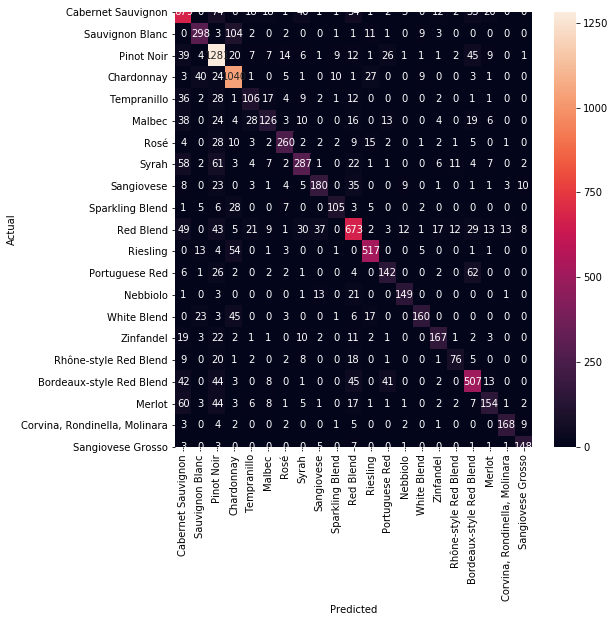

In [11]:
# Visualize confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()